In [26]:
# Imports for alpaca and .env 
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrame
import os
from pathlib import Path
load_dotenv()

True

In [27]:
# Set Alpca API key and secret key, then insantiate an API object
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECURITY_KEY")

tradeapi = REST(alpaca_api_key, alpaca_secret_key, api_version='v2')


In [28]:
from datetime import date
import re
# Define functions I use to get Alpaca Trade API data
def calc_start_date(years_ago):
    """Calculates the date 'x' years ago"""
    to_day=str(date.today())
    match = re.match(r'(\d\d\d\d)-(\d\d)-(\d\d)', to_day)
    _yrsago= int(match.group(1))-years_ago
    _yrsago = str(_yrsago)+'-'+match.group(2)+'-'+match.group(3)
    return _yrsago

def get_company(ticker, start, end, tradeapi):
    """Executes the get_bars method from Alpaca Trade API"""
    return tradeapi.get_bars(
        ticker,
        TimeFrame.Day,
        start,
        end
    ).df

# Get Data from API:
spy_df = get_company("SPY", calc_start_date(20), "2022-03-30", tradeapi)
spy_df.reset_index(inplace=True)
# spy_df.to_csv("../Data/rawdata/SPY_data.csv")


<AxesSubplot:>

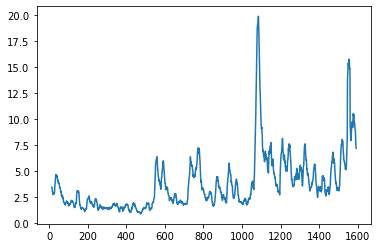

In [29]:
import pandas as pd
import numpy as np
# make a df with the values needed for the ATR calculation:
range_df = { 
               "date": spy_df['timestamp'] , 
               "hi-lo": abs( spy_df['high']-spy_df['low'] ), 
                "hi-cl": abs( spy_df['high'] - spy_df['close'].shift() ),
                "lo-cl": abs( spy_df['low'] - spy_df['close'].shift() )
}
# make a df out of our rage_df dictionary
range_df = pd.DataFrame(range_df)
# NaN exist because it subtracts the prior day's close, which doesn't exist in row one. Not important.
range_df.dropna(inplace=True)
range_df.set_index('date', inplace= True)

# Make a df of the maximum of ranges
true_range = pd.DataFrame( np.max(range_df, axis = 1) )
true_range.rename(columns= {0:'TR'}, inplace=True)
true_range.reset_index(inplace=True)

#plot a 14 day moving average of True Range (ATR)
true_range['TR'].rolling(14).mean().plot()




In [30]:

true_range.head()
true_range.to_csv("Data/rawdata/TR_data.csv")

In [31]:
vix_df = pd.read_csv('Data/cleandata/VIX_data.csv', index_col= 'timestamp')
spy_df = pd.read_csv('Data/cleandata/SPY_data.csv', index_col= 'timestamp')
my_price = spy_df.tail(1)['close'][0]
my_vol = vix_df.tail(1)['close'][0]


In [32]:
import Data.DataWrangle as dw
spy_df.drop(labels='id',axis=1, inplace= True)
combined_df = dw.combine_DFs([spy_df,vix_df],['SPY','VIX'])
combined_df.sort_index(inplace=True)
combined_df.dropna(inplace=True)




In [33]:
from libs.MCForecastTools import MCSimulation as MCsim

my_sim = MCsim(
    portfolio_data = combined_df,
    weights = [1,0],
    num_simulation = 100,
    num_trading_days = 252*2
)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


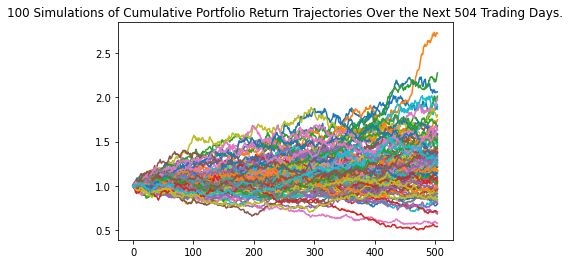

In [34]:
my_sim.plot_simulation()
my_returns = my_sim.simulated_return

In [35]:
spy_sim_df = (my_returns*my_price)
spy_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,...,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000
1,461.524017,454.718012,465.059122,455.279747,464.135774,457.054911,455.420466,461.457650,459.498036,450.880213,...,456.661878,456.367646,460.093623,460.493274,458.159346,456.357834,468.899635,464.256769,456.324576,454.042980
2,457.830257,451.543712,467.269047,454.115745,462.791814,454.448389,455.163926,456.805596,461.678873,450.766091,...,445.527672,453.799926,456.563167,461.694903,459.139576,458.466521,465.516234,462.226029,451.469258,452.086859
3,464.284695,440.872288,471.638428,447.122866,456.728947,454.223436,440.802566,452.509569,456.840162,454.304942,...,455.764294,459.414066,464.399820,457.510669,466.933200,465.090398,466.827427,455.602366,445.996518,453.653392
4,460.466513,439.745061,471.568325,450.204995,460.144095,456.323517,441.853543,447.770451,457.817775,451.396042,...,462.785763,460.826544,466.121107,447.283305,463.686031,469.745871,479.973816,460.607361,441.715983,462.240813


In [36]:
my_sim = MCsim(
    portfolio_data = combined_df,
    weights = [0,1],
    num_simulation = 100,
    num_trading_days = 252*2
)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


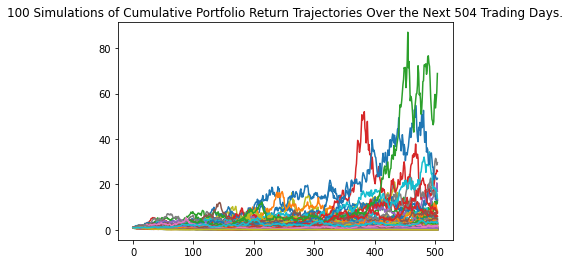

In [37]:
my_sim.plot_simulation()
my_returns = my_sim.simulated_return

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

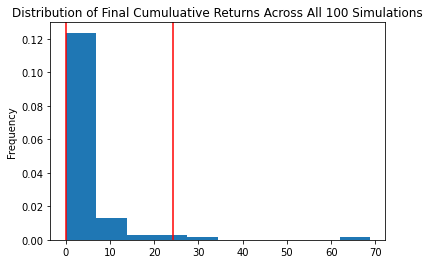

In [41]:
vix_sim_df = (my_returns*my_vol)
vix_sim_df.head()
my_sim.plot_distribution()

In [44]:
combined_df.tail()

SPY                                                  \
              open    high     low   close      volume trade_count   
timestamp                                                            
2022-03-23  446.90  448.49  443.71  443.80  77982935.0    627281.0   
2022-03-24  445.82  450.50  444.76  450.48  61411569.0    526865.0   
2022-03-25  451.09  452.98  448.43  452.69  77199328.0    661033.0   
2022-03-28  452.04  455.91  450.06  455.91  68356914.0    620868.0   
2022-03-29  461.75  462.07  457.18  461.55  86315479.0    735659.0   

                          VIX                       
                  vwap   open   high    low  close  
timestamp                                           
2022-03-23  446.058683  23.04  24.03  22.64  23.57  
2022-03-24  447.609014  23.61  23.79  21.49  21.67  
2022-03-25  451.047221  21.87  22.86  20.80  20.81  
2022-03-28  453.294974  22.14  23.33  19.54  19.63  
2022-03-29  459.632252  19.70  19.73  18.67  18.90

In [ ]:
# pseudocode for Historical Backtesting
# When Vix > threshold 
# CHOOSE SPY PRICE at timestamp == vix.timestamp
# Lookup (timestamp + number of weeks)
# find SPY PRICE at  timestamp+''
# (currentSPY - CHOSEN SPY) = change in price
# "Historically, when the VIX crosses 'x', the SPY has inc/dec 'y' amount
